# Zonal energy spectrum plots

* This notebook creates the ZES verification figure for the CREDIT paper

* The notebook runs with `plot_config.yml` in the same folder

In [1]:
import os
import sys
import yaml
import numpy as np
from datetime import datetime, timedelta

# graph tools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches

import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu

### load config

In [2]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [3]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

### Load ZES data

In [4]:
PLOT_data = np.load(conf['data']['save_loc'] + 'ZES_CREDIT_arXiv_2024_fuxi_wxformer.npy', allow_pickle=True)[()]

### Plot

**Figure specs**

In [5]:
def no_decimals(x, pos):
    return f'{int(x)}'
    
# color specs
my_colors = gu.ksha_color_set_summon(color_set=0)
colors_main = [my_colors['blue'], my_colors['orange'], my_colors['red']]

# line specs
line_keys = {}
line_keys['ERA5'] = {'linewidth': 3, 'linestyle': '--', 'color': '0.25', 'alpha': 1, 'zorder': 4, 'label': ''}
line_keys['IFS'] = {'linewidth': 3, 'linestyle': '-', 'color': colors_main[0], 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['wxformer'] = {'linewidth': 3, 'linestyle': '-', 'color': colors_main[1], 'alpha': 1, 'zorder': 3, 'label': ''}
line_keys['fuxi'] = {'linewidth': 3, 'linestyle': '-', 'color': colors_main[2], 'alpha': 1, 'zorder': 3, 'label': ''}

# labeling specs
wavenum = np.arange(1, len(PLOT_data['ZES_ERA5_KE'])+1)
k0 = 6
k1 = 60
model_names = ['ERA5', 'IFS', 'wxformer', 'fuxi']
varnames_plot = ['KE', 'theta']

titles = ['(a) 018-024 hour forecast', 
          '(b) 114-120 hour forecast', 
          '(c) 234-240 hour forecast', 
          '(d) 018-024 hour forecast', 
          '(e) 114-120 hour forecast', 
          '(f) 234-240 hour forecast']

lead_names = [24, 120, 240]
legned_labels = ['6 hourly ERA5', '6 hourly IFS', '6 hourly Wxformer', '6 hourly FuXi']

**Create the figure**

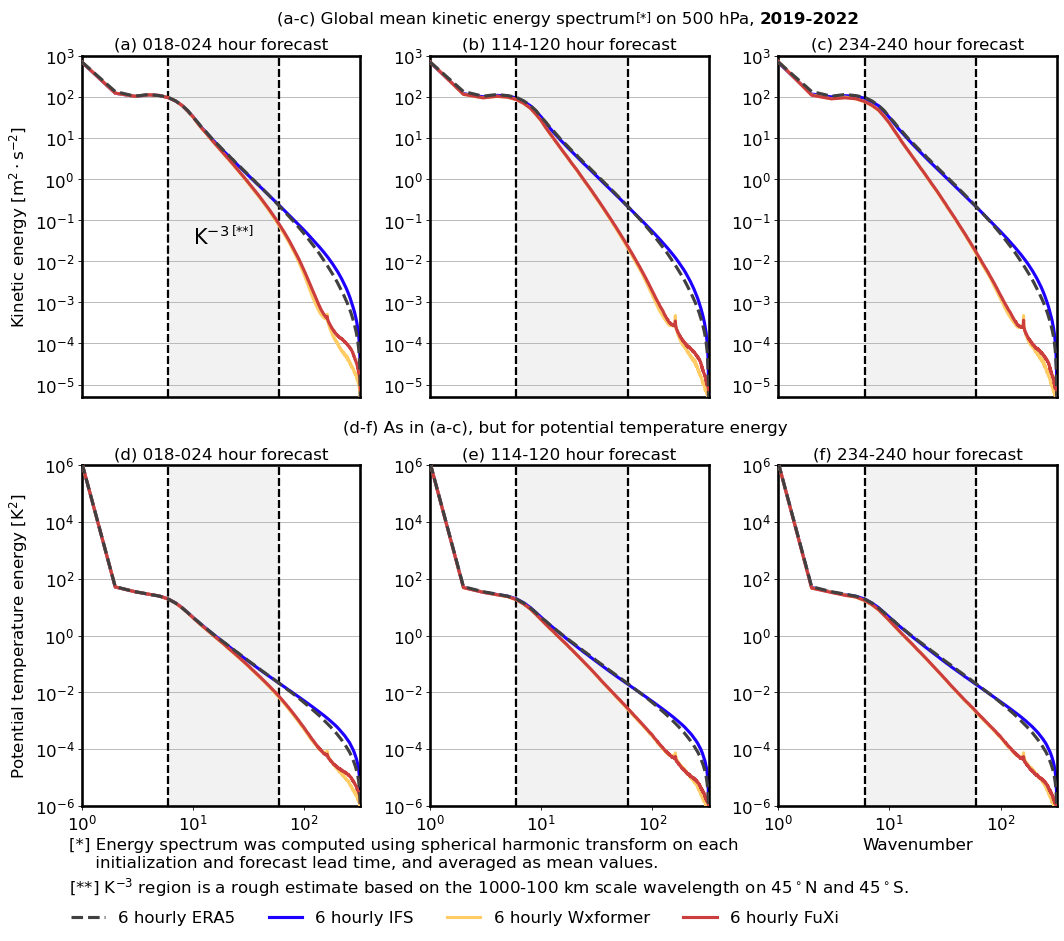

In [6]:
handles = []
h_ratios = [1, 0.2, 1]
w_ratios = [1, 0.25, 1, 0.25, 1]

fig = plt.figure(figsize=(13, 10), dpi=dpi_)
gs = gridspec.GridSpec(len(h_ratios), len(w_ratios),
                       height_ratios=h_ratios, width_ratios=w_ratios)

ind_x = [0, 2]
ind_y = [0, 2, 4]

AX = np.zeros((len(ind_x), len(ind_y)), dtype=object)
AX_flat = []

# Create main axes
for ix, ix_gs in enumerate(ind_x):
    for iy, iy_gs in enumerate(ind_y):
        ax_main = plt.subplot(gs[ix_gs, iy_gs])
        AX[ix][iy] = ax_main
        AX_flat.append(ax_main)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

# Configure all axes in AX_flat
for ax in AX_flat:
    ax = gu.ax_decorate_box(ax)
    
# Set x-tick labels for the bottom row
for iy in range(len(ind_y)):
    AX[1][iy].tick_params(labelbottom=True, labelsize=16)

# Configure left y-axis formatting
for ix in range(len(ind_x)):
    for iy in range(len(ind_y)):
        ax = AX[ix][iy]
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.xaxis.grid(False)
        ax.grid(':', axis='y')
        ax.set_xlim([wavenum[0], wavenum[-1]])
        ax.tick_params(labelsize=16, left=True, labelleft=True)
        if ix == 0:
            ax.set_ylim([5e-6, 1e3])
            ax.tick_params(bottom=False)
        else:
            ax.set_ylim([1e-6, 1e6])
            ax.tick_params(bottom=True)
            
AX[0][0].set_ylabel('Kinetic energy [$\mathsf{m^2\cdot s^{-2}}$]', fontsize=16)
AX[1][0].set_ylabel('Potential temperature energy [$\mathsf{K^2}$]', fontsize=16)
AX[1][2].set_xlabel('Wavenumber', fontsize=16)

AX[0][0].text(0.465, 0.47, '$\mathsf{K^{-3}}$', fontsize=20, ha='center', va='center', 
              transform=AX[0][0].transAxes, bbox=dict(facecolor='0.95', edgecolor='none'))

AX[0][0].text(0.58, 0.49, '[**]', fontsize=12, ha='center', va='center', 
              transform=AX[0][0].transAxes)

# AX[0][0].text(0.48, 0.44, '[**]', fontsize=12, ha='center', va='center', 
#               transform=AX[0][0].transAxes)

for ix, var in enumerate(varnames_plot):
    for iy, lead in enumerate(lead_names):
        for i_model, model_name in enumerate(['IFS', 'wxformer', 'fuxi']):
            AX[ix][iy].plot(wavenum, PLOT_data['ZES_{}_{}_{}'.format(model_name, lead, var)], 
                                  **line_keys['{}'.format(model_name)])

            AX[ix][iy].axvspan(xmin=k0, xmax=k1, color='0.95', zorder=1)
            AX[ix][iy].axvline(x=k0, color='k', linestyle='--', linewidth=2)
            AX[ix][iy].axvline(x=k1, color='k', linestyle='--', linewidth=2)
            
        AX[ix][iy].plot(wavenum, PLOT_data['ZES_ERA5_{}'.format(var)], **line_keys['ERA5'])
        # title
        AX[ix][iy].set_title(titles[3*ix+iy], fontsize=16)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['ERA5']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['IFS']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['wxformer']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi']))

ax_lg1 = fig.add_axes([-0.028, -0.17, 0.82, 0.05])
LG1 = ax_lg1.legend(handle_legneds1, legned_labels, 
                    bbox_to_anchor=(1, 1), ncol=4, prop={'size':16})

ax_title1 = fig.add_axes([0.0, 1.035, 1.0, 0.03])
title_len = 0.6
fontsize_list = [16,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal', 'bold', 'normal']
handles += gu.string_partial_format(fig, ax_title1, 0.5*(1-title_len), 0.8, 'left', 'top', 
                                    ['(a-c) Global mean kinetic energy spectrum    on 500 hPa, ', '2019-2022',], 
                                    ['k', 'k'], 
                                    fontsize_list, fontweight_list)
ax_title1.text(0.585, 0.85, '[*]', ha='right', va='top', fontsize=12, transform=ax_title1.transAxes);


ax_title2 = fig.add_axes([0.0, 0.49, 1.0, 0.03])
title_len = 0.465
fontsize_list = [16,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal', 'bold', 'normal']
handles += gu.string_partial_format(fig, ax_title2, 0.5*(1-title_len), 0.8, 'left', 'top', 
                                    ['(d-f) As in (a-c), but for potential temperature energy'], ['k'], 
                                    fontsize_list, fontweight_list)

w_p1 = '[*] Energy spectrum was computed using spherical harmonic transform on each\n'
w_p2 = '     initialization and forecast lead time, and averaged as mean values.'
ax_words1 = fig.add_axes([0, -0.0925, 0.75, 0.05])
ax_words1.text(-0.018, 1, w_p1+w_p2, ha='left', va='top', fontsize=16, transform=ax_words1.transAxes);

w_p1 = '[**] $\mathsf{K^{-3}}$ region is a rough estimate based on the 1000-100 km scale wavelength on 45$\mathsf{^\circ}$N and 45$\mathsf{^\circ}$S.'
ax_words2 = fig.add_axes([0, -0.1425, 0.75, 0.05])
ax_words2.text(-0.018, 1, w_p1, ha='left', va='top', fontsize=16, transform=ax_words2.transAxes);

LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()
ax_title1.set_axis_off()
ax_title2.set_axis_off()
ax_words1.set_axis_off()
ax_words2.set_axis_off()